# Giotto-Time

Welcome to `giotto-time`, our new library for time series forecasting!

Let's start with an example.

## First example

### Ingredients

These are the main ingredients of `giotto-time`:

In [1]:
import sys
sys.path.append('../')

In [21]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gtime.preprocessing import TimeSeriesPreparation
from gtime.compose import FeatureCreation
from gtime.feature_extraction import Shift, MovingAverage
from gtime.feature_generation import PeriodicSeasonal, Constant, Calendar
from gtime.model_selection import horizon_shift, FeatureSplitter
from gtime.forecasting import GAR
from gtime.time_series_models.base import TimeSeriesPipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- `TimeSeriesPreparation`: checks the input format of the time series and converts it to the expected format
- `DataFrameTransformer`: scikit-learn's `ColumnTransformer` wrapper that returns DataFrame
- `Shift`, `MovingAverage`: create the desired features on the time series for the forecasting
- `FeatureSplitter`: prepares the custom `giotto-time` train-test matrices that are used in the model
- `GAR`: Generalized Auto Regressive model, scikit-learn's `MultiOutputRegressor` wrapper. This is the only time series forecasting model available for the first release

We also need a scikit-learn regression model. We go for a standard `LinearRegression` for this example.

In [4]:
from sklearn.linear_model import LinearRegression

### Data

We use the `pandas.testing` module to create a testing time series

In [5]:
def test_time_series():
    from pandas.util import testing as testing

    testing.N, testing.K = 500, 1
    df = testing.makeTimeDataFrame( freq="D" )
    return df

In [6]:
time_series = test_time_series()
print(f'Time series shape: {time_series.shape}')
print(f'Time series index type: {time_series.index.__class__}')

Time series shape: (500, 1)
Time series index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>


### Time Series Preparation

The input time series has to be a `DataFrame` with a `PeriodIndex`. Use the provided class `TimeSeriesPreparation` to convert the time series into this format.

In [7]:
time_series_preparation = TimeSeriesPreparation()

In [8]:
period_index_time_series = time_series_preparation.transform(time_series)

In [9]:
print(f'Time series index type after the preprocessing: {period_index_time_series.index.__class__}')

Time series index type after the preprocessing: <class 'pandas.core.indexes.period.PeriodIndex'>


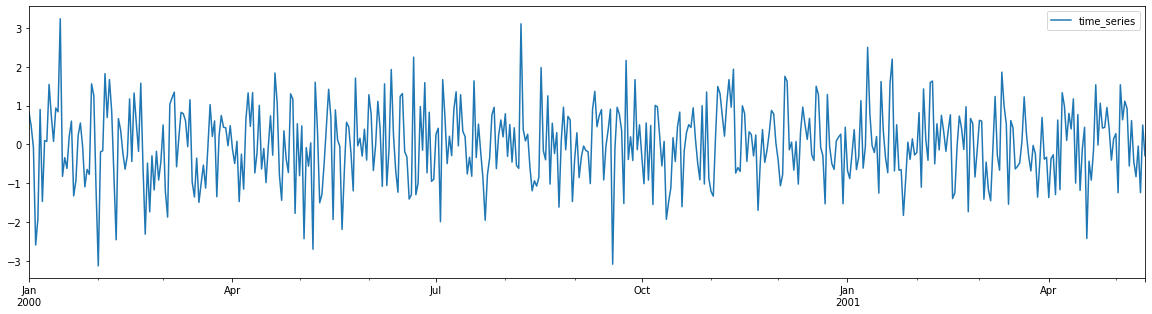

In [10]:
period_index_time_series.plot(figsize=(20, 5))
plt.show()

### Feature extraction

The feature extraction part is aimed at providing a scikit-learn paradigm with a time-series forecasting perspective
Our `DataFrameTransformer` inherits from scikit-learn's `ColumnTransformer`, it will create a feature DataFrame with the provided Transformers.

For simplicity we will create only `Shift` and `MovingAverage` features. 

`Shift` provides a temporal shift of the time series. Adding two `Shift` features (by 1 and 2) is equivalent to an `AR(2)` model. 

Since the `DataFrameTransformer` is a `ColumnTransformer` wrapper, you can easily include features from `scikit-learn`, `tsfresh`, topological features from `giotto-tda` (\o/) or your own custom features.

In [11]:
cal = Calendar(
    start_date="ignored",
    end_date="ignored",
    region="america",
    country="Brazil",
    kernel=np.array([0, 1]),
)
# New API 
dft = FeatureCreation(
    [('s1', Shift(1), ['time_series']), 
     ('s2', Shift(2), ['time_series']),
     ('ma3', MovingAverage(window_size=3), ['time_series']),
     # ('cal', cal, ['time_series']),
     # ('ct', Constant(2), ['time_series']),
    ])

In [12]:
X = dft.fit_transform(period_index_time_series)
X.head(6)

,s1__time_series__Shift,s2__time_series__Shift,ma3__time_series__MovingAverage
2000-01-01,NaN,NaN,NaN
2000-01-02,0.829722,NaN,NaN
2000-01-03,0.470912,0.829722,0.405574
2000-01-04,-0.083910,0.470912,-0.736190
2000-01-05,-2.595572,-0.083910,-1.534035
2000-01-06,-1.922621,-2.595572,-1.206470


In [13]:
y = horizon_shift(period_index_time_series, horizon=3)
y.head()

,y_1,y_2,y_3
2000-01-01,0.470912,-0.083910,-2.595572
2000-01-02,-0.083910,-2.595572,-1.922621
2000-01-03,-2.595572,-1.922621,0.898785
2000-01-04,-1.922621,0.898785,-1.473090
2000-01-05,0.898785,-1.473090,0.095200


### Train-Test split

We use `FeatureSplitter` to split the matrices X and y in train and test. 

In [14]:
feature_splitter = FeatureSplitter()

In [15]:
X_train, y_train, X_test, y_test = feature_splitter.transform(X, y)

### Training

We rewrapped scikit-learn's `MultiOutputRegressor` as `GAR` (Generalized Auto Regressive) model to better fit time series forecasting frameworks.

The traditional *AR* model is equivalent to the `GAR` model that uses only `Shift` columns in the `X` matrix.
`GAR` supports all the features compatible with the feature extraction step.

*AR*: https://en.wikipedia.org/wiki/Autoregressive_model

In [16]:
lr = LinearRegression()
model = GAR(lr)

In [17]:
model = model.fit(X_train, y_train)

### Forecasting

We forecast 3 time steps of the time series (we set this parameter in `horizon_shift` method).

The format of the output is the following:
- the index is the step at which the prediction is made.
- the column `y_1` is the prediction one time step after and so on for `y_2` and `y_3`

In [18]:
predictions = model.predict(X_test)

In [19]:
predictions

,y_1,y_2,y_3
2001-05-12,-0.007442,0.062762,0.045743
2001-05-13,0.066994,0.014059,-0.007383
2001-05-14,0.002460,0.009264,0.024057


### Forecasting with pipeline

In [26]:
time_series_pipeline = TimeSeriesPipeline(features=dft, horizon=3, model=GAR(lr))

In [27]:
time_series_pipeline.fit(period_index_time_series)

In [29]:
time_series_pipeline.predict()

,y_1,y_2,y_3
2001-05-12,-0.007442,0.062762,0.045743
2001-05-13,0.066994,0.014059,-0.007383
2001-05-14,0.002460,0.009264,0.024057
